# Loading the data, an example

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


There are two folders that contains the CSV data :

- Countries
- Continents

As their names suggest, Countries contains the data for different countries and Continents the data for different continents. The architecture is the same for both folders. For each country/continent, their are 4 subfolders :

- Nodes : contains the raw nodes data
- Edges : contains the raw edges data
- gml : contains the graphs in gml format
- PNG : contains images of the graphs (Blue nodes : stations, red nodes : generators, white nodes : joints)

In the folders Nodes and Edges there are two kinds of files :

- Highvoltage CSV file : contains raw data of the highvoltage network. This does NOT contain information on generators
- Heuristic CSV file : contains raw data of the whole networks. This contains information on generators. Be carefull, as it name suggests, these data come from heuristic algorithms that tries to make sense out of incomplete Openstreet data. The networks obtain should therefore be treated as approximation of the true networks.

Therefore, there are two kinds of graphs in the gml and PNG folders : highvoltage networks and Heuristic networks.

## The easy way

The easiest way to load the graphs is to use directly the gml files. NetworkX, one of the most used python library to handle graphs, has a method that reads gml files. In this example notebook, we assume that we want to load the heuristic graph of Spain.

In [2]:
import networkx as nx
geo        = 'Continents'   #Replace by Continents
country    = 'Europa'     #Replace by the country of interest

#Make sure the notebook is in the right folder
path_nodes_gml = './%s/%s/graphml/%s_heuristic.graphml'%(geo,country,country)

In [3]:
G = nx.read_graphml(path_nodes_gml)

## The hard way

The other way to load the graphs is to work directly with the raw CSV files. These data were cleaned but still contain some bugs.

### Nodes data

In [4]:
path_nodes = './%s/%s/Nodes/heuristic_vertices.csv'%(geo,country)

In [5]:
#For most files it is possible (and easier) to load it directly in pandas
#But some files may have bugs and some nodes/lines should be discarded
import csv
nodes=[]
with open(path_nodes, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter='#') #delimiters were chosen to be #
    columns_nodes = reader.next()
    columns_nodes = [ c.replace('_','') for c in columns_nodes ] #Get rid of _ for the column names
    print columns_nodes

    for row in reader:
        if len(row)==len(columns_nodes):
            nodes.append(row)

['vid', 'lon', 'lat', 'typ', 'voltage', 'frequency', 'name', 'operator', 'ref', 'source', 'ngen', 'capacity', 'netcapacity', 'wktsrid4326']


In [6]:
import pandas as pd
#Loading the nodes in a Pandas Dataframe
nodes = pd.DataFrame(nodes, columns=columns_nodes)
print nodes.head(2)

     vid               lon               lat         typ voltage frequency  \
0  24046  7.18335705905258  50.1970892564064  substation                     
1  24047  15.7114407147978  46.7523004687977  substation                     

  name operator ref source ngen capacity netcapacity  \
0                                                      
1                                                      

                                         wktsrid4326  
0  SRID=4326;POINT(7.18335705905258 50.1970892564...  
1  SRID=4326;POINT(15.7114407147978 46.7523004687...  


In [7]:
#Convert ID, longitude, and latitude to proper types
#Similar operations can be done for the other columns if needed
nodes['vid'] = nodes['vid'].apply(lambda x:int(x))
nodes['lat'] = nodes['lat'].apply(lambda x:float(x))
nodes['lon'] = nodes['lon'].apply(lambda x:float(x))

In [8]:
#Node types present in this example
print np.unique(nodes['typ'].values)

['gas generator' 'generator' 'heliostat' 'hydro' 'hydroelectric' 'joint'
 'merge' 'merged_generator' 'plant' 'station' 'sub_station' 'substation'
 'wind generator']


### Edge data

In [9]:
path_edges = './%s/%s/Edges/heuristic_links.csv'%(geo,country)
edges=[]
with open(path_edges, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter='#')
    columns_edges = reader.next()
    columns_edges = [ c.replace('_','') for c in columns_edges ] #Get rid of _ for the column names
    print columns_edges

    for row in reader:
        if len(row)==len(columns_edges):
            edges.append(row)

['lid', 'vid1', 'vid2', 'voltage', 'cables', 'wires', 'frequency', 'name', 'operator', 'ref', 'lengthm', 'rohmkm', 'xohmkm', 'cnfkm', 'ithmaxa', 'fromrelation', 'wktsrid4326', 'type']


In [10]:
edges = pd.DataFrame(edges, columns=columns_edges)
print edges.head(2)

    lid   vid1   vid2 voltage cables wires frequency  \
0  2269  53207  86410  110000      3                   
1  6700  37311  37375  132000      6              50   

                             name operator ref           lengthm rohmkm  \
0  110kV Pasikurowice - Trzebnica               13151.0489640662          
1                                               44.7641013764591          

  xohmkm cnfkm ithmaxa fromrelation  \
0                                ''   
1                                ''   

                                         wktsrid4326  type  
0  SRID=4326;LINESTRING(17.1189249068728 51.21376...  line  
1  SRID=4326;LINESTRING(-0.163076792931227 51.114...  line  


In [11]:
#Convert IDs to proper types
#Similar operations can be done for the other columns if needed
edges['lid']  = edges['lid'].apply(lambda x:int(x))
edges['vid1'] = edges['vid1'].apply(lambda x:int(x))
edges['vid2'] = edges['vid2'].apply(lambda x:int(x))

### Building the graph

In [12]:
G = nx.Graph()
G.add_nodes_from(nodes['vid'].values)

#Load the nodes data in the graph
for col in columns_nodes:
    if col != 'vid':
        nx.set_node_attributes(G, col, 
                               {k:str(v) for k,v in zip( nodes['vid'].values, 
                                                         nodes[col].values)})

In [13]:
print G.nodes(data=True)[0]

(262145, {'capacity': '', 'name': '', 'source': 'solar', 'ref': '', 'lon': '12.8881070812', 'operator': '', 'ngen': '1', 'frequency': '', 'voltage': '', 'lat': '43.7918713427', 'wktsrid4326': 'SRID=4326;POINT(12.8881070812285 43.7918713426575)', 'typ': 'generator', 'netcapacity': ''})


In [14]:
G.add_edges_from([(n1,n2) for n1,n2 in zip(edges['vid1'].values, 
                                           edges['vid2'].values)])
#Load the edges data in the graph
for col in edges.columns:
    if 'vid' not in col:
        nx.set_edge_attributes(G, col, 
                               {(a,b):str(v) for a,b,v in zip(edges['vid1'], 
                                                              edges['vid2'],
                                                              edges[col])})

In [15]:
print G.edges(data=True)[0]

(262145, 52721, {'lid': '861469', 'ithmaxa': '', 'wires': '', 'xohmkm': '', 'name': '', 'ref': '', 'fromrelation': '', 'cnfkm': '', 'frequency': '', 'voltage': '', 'lengthm': '7570.31386528363', 'type': 'Created_line', 'operator': '', 'wktsrid4326': 'SRID=4326;LINESTRING(12.8881070812285 43.7918713426575,12.9558417677077 43.7874962654839)', 'cables': '', 'rohmkm': ''})


### Generators, substations, and joints

In [16]:
#It might be the case that nodes were created without having a type field
#Here, we filter these nodes out of the graph
G.remove_nodes_from( 
    [node[0] for node in G.nodes(data=True) if not node[1].has_key('typ')] )

We create the three following lists :

- generators : contains the IDs of nodes considered as generators
- stations : contains the IDs of nodes considered as substations
- others : contains the IDs of nodes that are not generators or substations (mainly joints)

In [17]:
generators = [node[0] for node in G.nodes(data=True) 
                        if node[1]['typ']=='generator' or
                           node[1]['typ']=='merged_generator' or
                           node[1]['typ']=='plant' or
                           node[1]['typ']=='hydro' or
                           node[1]['typ']=='hydroelectric' or
                           node[1]['typ']=='heliostat']

In [18]:
stations = [node[0] for node in G.nodes(data=True) 
                        if node[1]['typ']=='station' or
                           node[1]['typ']=='sub_station' or
                           node[1]['typ']=='substation']

In [19]:
others = [node[0] for node in G.nodes(data=True) if node[0] not in generators and 
                                                    node[0] not in stations]

In [20]:
assert len(generators) + len(stations) + len(others) == len(G.nodes())
print """G contains %d nodes and %d edges.
There are %d generators, 
          %d substations, and 
          %d joints"""%(G.number_of_nodes(),
                        G.number_of_edges(),
                        len(generators),len(stations),len(others))

G contains 107680 nodes and 115933 edges.
There are 39933 generators, 
          40498 substations, and 
          27249 joints


### Ploting the graph

In this section, we plot the graph using the basemap module.

In [144]:
#Returns the longitude of a given node
def get_longitude( node_id ):
    return nodes.ix[ nodes['vid'] == node_id, 'lon'].values[0]

#Returns the latitude of a given node
def get_latitude( node_id ):
    return nodes.ix[ nodes['vid'] == node_id, 'lat'].values[0]

The following function gets the coordinates for the bounding box. These coordinates are stored in a text file called "Bounding_Boxes.txt" located at the root of the project folder. The coordinates are in mercator projection and the format of the text file is the following :

name;x1;x2;y1;y2

Where :

- name stands for the country/continent name
- x1 stands for the lower left corner longitude
- x2 stands for the upper right corner longitude
- y1 stands for the lower left corner latitude
- y2 stands for the upper right corner latitude

In [145]:
def get_bb(country):
    try:
        with open('./Bounding_Boxes.txt', 'r') as f:
            bb = map(int, filter(lambda x:country in x, f.readlines())[0].split(';')[1:])
        return bb
    except:
        print 'error while loading bounding box coordinates'
        return None

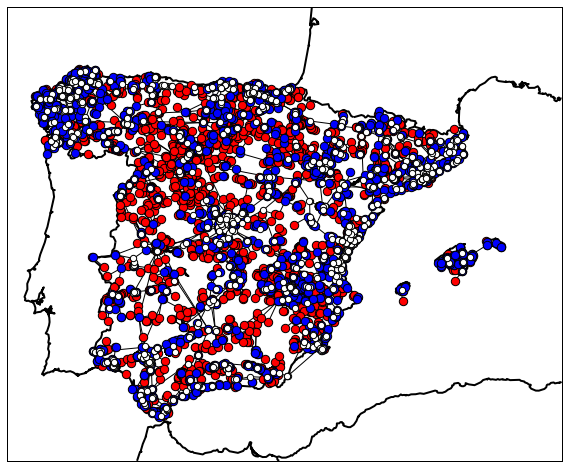

In [53]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)

#Bounding box
x1, x2, y1, y2 = get_bb(country)

m = Basemap(resolution='i',
            projection='merc', 
            llcrnrlat=y1,
            urcrnrlat=y2,
            llcrnrlon=x1,
            urcrnrlon=x2,
            lat_ts=20)

m.drawcountries(linewidth=2)
m.drawcoastlines(linewidth=2)

pos = dict((int(node), 
            m(get_longitude( int(node) ), 
              get_latitude( int(node) )) ) for node in G.nodes())

nx.draw_networkx_nodes(G, pos, nodelist=generators, node_size = 70, node_color = 'r')
nx.draw_networkx_nodes(G, pos, nodelist=stations,   node_size = 70, node_color = 'b')
nx.draw_networkx_nodes(G, pos, nodelist=others,     node_size = 40, node_color = 'w')

nx.draw_networkx_edges( G, pos)

plt.tight_layout()
plt.show()

In [21]:
nx.write_graphml(G,'./Continents/%s/graphml/%s_heuristic.graphml'%(country,country))

In [471]:
nx.write_graphml(G,'./Countries/%s/graphml/USA_South_highvoltage.graphml'%(country))

In [22]:
G.number_of_nodes()

107680

In [25]:
G2=nx.read_graphml('./Continents/%s/graphml/%s_heuristic.graphml'%(country,country))

MemoryError: 

In [473]:
G2=nx.read_graphml('./Countries/%s/graphml/USA_South_highvoltage.graphml'%(country))

In [49]:
G2.number_of_nodes()

5066

In [243]:
G2.nodes(data=True)[900]

IndexError: list index out of range

In [12]:
with open('./Continents/Europa/graphml/Europa_heuristic.graphml', 'r') as f:
    data=f.read()

In [14]:
len(data)/5.

25336079.0

In [15]:
chunk_size = len(data)/5
chunks = [data[i*chunk_size:(i+1)*chunk_size] for i in range(5)]

In [16]:
np.sum(map(len,chunks))==len(data)

True

In [17]:
for i,chunk in enumerate(chunks):
    with open('./Continents/Europa/graphml/Europa_heuristic_part_%d.graphml'%(i+1), 'w') as f:
        f.write(chunk)